# UNIT 4 Challenge Build your NLP model

In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
clf = ensemble.GradientBoostingClassifier()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

## Data used

The data I chose to use was a few different books from the gutenberg collection, I chose books from the authors shakepeare and austen. 

## Bag of Words

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [4]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text


# Import all the Speakspeare in the Project Gutenberg corpus.
shakespeare = ""
for novel in ['caesar','hamlet']:
    work = gutenberg.raw('shakespeare-' + novel + '.txt')
    shakespeare = shakespeare + work

# Clean the data.
shakespeare_clean = text_cleaner(shakespeare)

In [6]:
emma = gutenberg.raw('austen-emma.txt')
sense = gutenberg.raw('austen-sense.txt')
persuasion = gutenberg.raw('austen-persuasion.txt')
# Clean the data.
persuasion_clean = text_cleaner(persuasion)
sense_clean = text_cleaner(persuasion)
emma_clean = text_cleaner(emma)

In [5]:
# Parse the data. This can take some time.
nlp = spacy.load('en')
shakespeare_doc = nlp(shakespeare_clean)

C:\Users\blindside\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\blindside\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [7]:
sense_doc = nlp(sense_clean)
persuasion_doc = nlp(persuasion_clean)
emma_doc = nlp(emma_clean)

In [8]:
# Group into sentences.
sense_sents = [[sent, "Austen"] for sent in sense_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]
shakespeare_sents = [[sent, "Shakespeare"] for sent in shakespeare_doc.sents]
# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(sense_sents + persuasion_sents+emma_sents+shakespeare_sents)
sentences.head()

# Combine the sentences from the two novels into one data frame.

sentences.head()

,0,1
0,"(Sir, Walter, Elliot, ,, of, Kellynch, Hall, ,...",Austen
1,"(This, was, the, page, at, which, the, favouri...",Austen
2,"(Walter, Elliot, ,, born, March, 1, ,, 1760, ,...",Austen
3,"(of, South, Park, ,, in, the, county, of, Glou...",Austen
4,"("", Precisely, such, had, the, paragraph, orig...",Austen


In [9]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
sensewords = bag_of_words(sense_doc)
persuasionwords = bag_of_words(persuasion_doc)
emmawords = bag_of_words(emma_doc)
shakespearewords = bag_of_words(shakespeare_doc)

In [28]:
# Combine bags to create a set of unique words.
common_words = set(sensewords + persuasionwords + emmawords + shakespearewords)

In [29]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500
Processing row 11000
Processing row 11500
Processing row 12000
Processing row 12500
Processing row 13000
Processing row 13500
Processing row 14000
Processing row 14500
Processing row 15000
Processing row 15500
Processing row 16000
Processing row 16500
Processing row 17000
Processing row 17500
Processing row 18000
Processing row 18500
Processing row 19000
Processing row 19500
Processing row 20000
Processing row 20500
Processing row 21000


,unquestionably,siluer,difficult,relinquish,box,abruptly,assur'd,happily,mightier,pretend,...,reasons,rat,fear'd,discussion,stomacke,anxiously,weakness,remarkable,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Sir, Walter, Elliot, ,, of, Kellynch, Hall, ,...",Austen
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(This, was, the, page, at, which, the, favouri...",Austen
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Walter, Elliot, ,, born, March, 1, ,, 1760, ,...",Austen
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(of, South, Park, ,, in, the, county, of, Glou...",Austen
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"("", Precisely, such, had, the, paragraph, orig...",Austen


In [68]:
rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

print('Scores:', cross_val_score(rfc, X, Y, cv=5))

Scores: [0.93348891 0.9428238  0.92298716 0.91946779 0.90196078]


In [69]:
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(rfc, X, Y, scoring=scoring,
             cv=5, return_train_score=True)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_precision_macro',
 'test_recall_macro',
 'train_precision_macro',
 'train_recall_macro']

In [74]:
scores

{'fit_time': array([16.55346394, 16.11014652, 18.10299349, 15.75453615, 15.92314649]),
 'score_time': array([0.80586815, 0.91855454, 0.8053515 , 0.80186653, 0.81383395]),
 'test_precision_macro': array([0.95686182, 0.9635156 , 0.90855035, 0.89723602, 0.87642342]),
 'test_recall_macro': array([0.86600017, 0.88108074, 0.86711279, 0.85600286, 0.84484423]),
 'train_precision_macro': array([0.9881152 , 0.98961219, 0.989959  , 0.99086717, 0.99102054]),
 'train_recall_macro': array([0.97663232, 0.97568031, 0.97959336, 0.9785745 , 0.98047023])}

In [ ]:
confusion_matrix(Y, y_pred)

In [15]:
lr = LogisticRegression()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

print('Scores:', cross_val_score(lr, X, Y, cv=5))

Scores: [0.93722287 0.94165694 0.93768961 0.94397759 0.92623716]


In [22]:
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(lr, X, Y, scoring=scoring,
             cv=5, return_train_score=True)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_precision_macro',
 'test_recall_macro',
 'train_precision_macro',
 'train_recall_macro']

In [23]:
scores

{'fit_time': array([17.92023873, 15.94388509, 14.74556851, 14.74376011, 14.48648715]),
 'score_time': array([1.12905717, 1.10776544, 1.05999756, 1.04199386, 1.12530017]),
 'test_precision_macro': array([0.95418051, 0.95693887, 0.94025947, 0.95184653, 0.92447546]),
 'test_recall_macro': array([0.87522223, 0.88438327, 0.88701778, 0.89403042, 0.86951222]),
 'train_precision_macro': array([0.97365626, 0.97291636, 0.97305699, 0.97653598, 0.97589536]),
 'train_recall_macro': array([0.94045553, 0.94002191, 0.94704745, 0.9468877 , 0.94931954])}

In [79]:
lr_params = {'C':np.arange(0.00001, 3, .01)}

In [81]:
lr = LogisticRegression()
gs_lr = GridSearchCV(lr, lr_params, return_train_score=True, n_jobs =-1)
gs_lr.fit(X,Y)

print(gs_lr.best_params_)

{'C': 2.9900100000000003}


In [82]:
lr = LogisticRegression(C= 2.9900100000000003)
cross_val_score(lr, X, Y, cv=5)

array([0.94469078, 0.94749125, 0.94165694, 0.94747899, 0.93043884])

Normally I would not stop at this point with the suggested number being so close to 3 I would have checked higher numbers, however just finding the best fit so far took hours and I didn't want to take too much more time without a good reason.

In [83]:
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(lr, X, Y, scoring=scoring,
             cv=5, return_train_score=True)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_precision_macro',
 'test_recall_macro',
 'train_precision_macro',
 'train_recall_macro']

In [84]:
scores

{'fit_time': array([7.94875026, 7.93678331, 7.92780685, 7.94376445, 7.95274043]),
 'score_time': array([0.78689599, 0.78290677, 0.78190994, 0.78290725, 0.78390479]),
 'test_precision_macro': array([0.95793333, 0.96104257, 0.94128583, 0.95144085, 0.92666633]),
 'test_recall_macro': array([0.89130779, 0.89610905, 0.8968556 , 0.9035706 , 0.87918553]),
 'train_precision_macro': array([0.98056166, 0.9801132 , 0.98245357, 0.98379123, 0.98247519]),
 'train_recall_macro': array([0.9576805 , 0.95809106, 0.96358981, 0.96454731, 0.96577856])}

In [16]:
svc = SVC()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

print('Scores:', cross_val_score(svc, X, Y, cv=5))

Scores: [0.757993   0.757993   0.757993   0.75816993 0.75816993]


In [17]:
clf = ensemble.GradientBoostingClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

print('Scores:', cross_val_score(clf, X, Y, cv=5))

Scores: [0.84854142 0.84434072 0.86067678 0.84943978 0.8557423 ]


In [ ]:
scores

## tf-idf

In [49]:
emma_para=gutenberg.paras('austen-emma.txt')
emma_paras=[]
for paragraph in emma_para:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [50]:
sense_para=gutenberg.paras('austen-sense.txt')
sense_paras=[]
for paragraph in sense_para:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    sense_paras.append(' '.join(para))

print(sense_paras[0:4])

['[ Sense and Sensibility by Jane Austen 1811 ]', 'CHAPTER 1', 'The family of Dashwood had long been settled in Sussex .', 'By a former marriage , Mr . Henry Dashwood had one son : by his present lady , three daughters .']


In [51]:
persuasion_para=gutenberg.paras('austen-persuasion.txt')
persuasion_paras=[]
for paragraph in persuasion_para:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    persuasion_paras.append(' '.join(para))

print(persuasion_paras[0:4])

['[ Persuasion by Jane Austen 1818 ]', 'Chapter 1', 'Sir Walter Elliot , of Kellynch Hall , in Somersetshire , was a man who , for his own amusement , never took up any book but the Baronetage ; there he found occupation for an idle hour , and consolation in a distressed one ; there his faculties were roused into admiration and respect , by contemplating the limited remnant of the earliest patents ; there any unwelcome sensations , arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the last century ; and there , if every other leaf were powerless , he could read his own history with an interest which never failed .', '" ELLIOT OF KELLYNCH HALL .']


In [54]:
shakespeare_para=gutenberg.paras('shakespeare-caesar.txt')
shakespeare_paras=[]
for paragraph in shakespeare_para:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    shakespeare_paras.append(' '.join(para))

print(shakespeare_paras[0:4])

['[ The Tragedie of Julius Caesar by William Shakespeare 1599 ]', 'Actus Primus .', 'Enter Flauius , Murellus , and certaine Commoners ouer the Stage .', 'Flauius .']


In [55]:
shakespeareH_para=gutenberg.paras('shakespeare-hamlet.txt')
shakespeareH_paras=[]
for paragraph in shakespeareH_para:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    shakespeareH_paras.append(' '.join(para))

print(shakespeareH_paras[0:4])

['[ The Tragedie of Hamlet by William Shakespeare 1599 ]', 'Actus Primus .', 'Enter Barnardo and Francisco two Centinels .', 'Barnardo .']


In [56]:
combined_text = set(persuasion_paras + sense_paras + emma_paras + shakespeare_paras + shakespeareH_paras)

In [58]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
combined_tfidf=vectorizer.fit_transform(combined_text)
print("Number of features: %d" % combined_tfidf.get_shape()[1])

Number of features: 3616


In [63]:
svd= TruncatedSVD(850)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X = lsa.fit_transform(combined_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X,index=combined_tfidf)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 74.37814139113351
Component 0:
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
  (0, 526)\t1.0    0.999888
Name: 0, dtype: float64
Component 1:
  (0, 329)\t0.34070220369023074\n  (0, 1066)\t0.19257993845870164\n  (0, 1491)\t0.25053038987501547\n  (0, 1551)\t0.2403190297873283\n  (0, 1779)\t0.3888185872460871\n  (0, 1845)\t0.25267391253475224\n  (0, 1850)\t0.24270079141870707\n  (0, 2131)\t0.18037289937748455\n  (0, 2132)\t0.1788158921701223\n  (0, 2255)\t0.30997346038264173\n  (0, 2824)\t0.17465791927685714\n  (0, 3004)\t0.2980302332125442\n  (0, 3255)\t0.24487234112034648\n  (0, 3257)\t0.22784770657617548\n  (0, 3528)\t0.24615256971933203    0.484256
  (0, 1066)\t0.32883454219770447\n  (0, 1845)\t0.4314463438853268\n  (0, 2131)\t0.307990750

Name: 2, dtype: float64
Component 3:
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
  (0, 3607)\t1.0    0.878691
Name: 3, dtype: float64
Component 4:
  (0, 812)\t0.5385107671269052\n  (0, 1066)\t0.842618628851981                                                                       0.792323
  (0, 812)\t0.7876000358838147\n  (0, 1066)\t0.616186808910913                                                                       0.730048
  (0, 1066)\t1.0                                                                                                                     0.695649
  (0, 1066)\t1.0                                                                                                                     0.695649
  (0, 1066)\t1.0                                                    

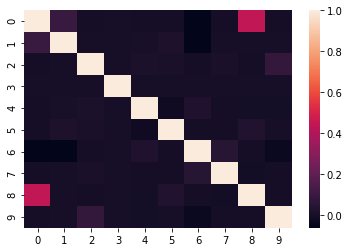

Key:
0 [ 5.04114296e-05  4.59944068e-01  2.38033433e-01 -2.03932018e-02
  1.02026450e-01 -2.69494606e-03 -9.73395401e-02 -1.33438421e-01
 -1.13677153e-01 -7.55054175e-03 -3.24053695e-02 -8.80889894e-02
 -8.91567491e-02 -6.31385475e-02  1.83400616e-01 -1.10420010e-01
  7.41891678e-03 -1.58832976e-01 -4.22586546e-02 -1.23876079e-01
  3.69158050e-02 -4.63221132e-02 -1.01504753e-01  5.54663292e-02
  4.19266710e-02 -1.53018355e-01  2.64134280e-01 -1.85489740e-01
  3.38205016e-02  3.68249368e-02 -2.49599426e-02 -7.85187098e-02
  7.75410958e-03 -4.78722827e-02 -1.59079155e-01 -1.13768639e-01
 -6.92878742e-03  3.36907339e-02 -1.95706083e-02  1.28094182e-01
 -7.29838676e-02  8.25849384e-02 -6.86742658e-02  1.14536354e-01
 -2.17280873e-03  1.82815847e-02  4.72132238e-02  6.95238575e-02
  6.93266284e-02  7.66508688e-03 -8.75829760e-03 -2.38745234e-02
  3.12987637e-02 -2.54214833e-02  1.37958919e-02 -7.61047757e-02
  4.07334241e-02 -4.69009545e-03 -1.46674448e-02  4.49036321e-03
 -8.54075273e-03  

 -2.41394222e-02 -2.77343432e-02]
1 [ 1.48343373e-05  1.45007265e-01  8.63422695e-02 -2.40861796e-02
  2.95304477e-01 -2.46313161e-03  1.18663246e-01 -2.06458143e-01
  3.68060130e-02 -1.87393405e-02 -1.09982695e-02 -9.28774262e-02
  1.87386705e-02 -6.19703615e-03 -4.19152915e-02  1.33859221e-02
  2.80403153e-02  3.50125208e-02 -1.06153147e-02 -6.22331929e-02
 -4.64282033e-02 -2.80814612e-02 -2.12464556e-02  2.91357177e-02
  4.05038308e-02 -1.76200963e-02  8.88712330e-03 -6.01664721e-02
  8.25904946e-03 -1.06516507e-01 -3.16362424e-02  2.11063826e-01
 -2.08587484e-02  8.72147877e-02 -9.36470305e-02  1.28003603e-02
 -3.57575476e-02 -1.34750711e-01  1.01420699e-01  2.19139355e-02
  1.17343645e-01 -4.66221309e-02  1.29604249e-01 -1.17482344e-01
 -6.09345773e-02 -4.17558211e-02  5.95902504e-02  3.50981715e-02
 -1.30350383e-01 -6.87430516e-02  1.10062093e-02  1.97561385e-02
 -3.46295307e-02 -1.94151944e-02  1.05843003e-02 -4.35729638e-02
 -4.45545775e-02 -6.72420020e-03  4.10852901e-02  2.22

  5.43865298e-03 -3.36490270e-02]
2 [ 1.88759745e-05  1.40506535e-01 -3.26286380e-02 -8.29329928e-03
 -7.92664815e-02  1.64203151e-02  1.14340658e-01  3.05327469e-03
  5.00027214e-02  4.33919587e-02  1.59324295e-02  1.73918792e-01
  2.59569039e-02 -7.62354463e-02 -1.11541187e-01  6.31761573e-02
  3.56508206e-02 -1.52197595e-03 -3.55730050e-02 -4.06031149e-02
 -4.85051622e-02  6.55552675e-03 -5.68318814e-02 -2.04594702e-02
  1.52533540e-02  9.37433378e-03 -7.28908056e-02 -9.09147135e-02
  1.98738750e-03 -1.49716907e-02  1.61475552e-02 -3.69745866e-02
 -3.31704495e-02  1.16523433e-01  5.55660447e-02 -4.79070866e-02
 -3.29624678e-02 -2.15453710e-03 -7.80397173e-04  5.04408333e-02
  1.03339834e-02  4.07208518e-02 -3.52436557e-02 -2.60349897e-03
  3.73914009e-02  1.22242963e-02 -1.09952211e-02  3.08809242e-02
  3.80830911e-02 -2.01804796e-02 -7.23552865e-02  4.42655490e-02
  4.12606119e-02 -4.35590662e-02  2.62368612e-02 -2.58465677e-02
 -2.39982274e-02 -6.79111968e-03  3.76419373e-03 -5.07

 -1.06588005e-02 -1.73964953e-03]
3 [ 9.99888297e-01 -1.28914159e-04 -4.96134568e-06 -1.08733263e-06
  2.07730367e-05 -8.58375479e-06  3.59217944e-06  1.30184473e-06
 -1.52631259e-05  5.87583692e-07 -5.21694254e-07 -3.65920660e-05
  1.74968099e-05  1.87339231e-05  2.37192576e-05 -1.34165310e-05
 -1.18666666e-05 -1.94826485e-05 -5.91439315e-05  2.50280871e-05
  8.19636806e-06 -2.67772270e-05  9.30524524e-06  2.42363787e-05
 -9.70237642e-06 -8.54968685e-06  8.31067482e-07  6.22497930e-07
 -3.78044948e-06  3.91958478e-06 -1.29749899e-05 -2.31137599e-05
  2.31824356e-06 -2.17938075e-05 -1.84246904e-05 -1.76183373e-05
 -5.24415618e-06 -2.46461716e-06 -9.87967739e-06  4.30707959e-06
  5.41632978e-06  7.71181194e-08  3.03800207e-05 -4.80161962e-06
 -1.50610403e-05 -2.07473314e-05  7.25268379e-06  7.49584900e-05
  6.43181909e-07  3.12982686e-05 -7.59571341e-05  3.96250194e-05
 -3.09716700e-05 -1.87486674e-05  3.66405665e-06 -2.12217844e-05
  1.56787165e-05 -2.57492793e-05  2.44127444e-05  3.52

 -2.93762630e-03  5.42983621e-05]
4 [ 4.65148453e-06  4.21286572e-02 -1.52659235e-03 -1.20838005e-03
  6.70798321e-04 -9.68014623e-03  1.70612298e-02 -6.38186175e-03
  3.00077882e-02  1.39816215e-03 -1.64893873e-03  1.16587919e-02
 -1.37064011e-02  4.44512547e-03 -1.67845103e-02  9.58384993e-03
 -6.46891813e-03 -1.38710556e-03  3.09389344e-03  1.40226114e-02
 -3.10299599e-03  1.34208373e-02 -2.54032641e-03 -1.53717911e-02
 -2.89121692e-03  6.12133757e-03 -7.14516427e-03 -1.12101954e-02
  1.45164098e-02  6.85770145e-03 -5.26419152e-03 -2.73337493e-02
 -8.59603848e-04 -1.87666093e-02  1.37709106e-02 -2.03821973e-02
  2.18208908e-03  6.87772233e-03  2.27342173e-03 -2.70693988e-02
 -3.07505911e-03 -7.88825198e-03  2.44585156e-02 -2.88924715e-02
 -4.95074711e-02 -1.45798953e-02 -4.86089746e-02  3.87974747e-02
  8.68910966e-02 -2.99374195e-02 -2.57297139e-02  6.26382163e-02
 -2.20614808e-02  7.18808301e-02 -1.05218544e-01 -1.40859398e-01
 -2.77785729e-02  1.79196538e-01 -4.15947524e-02 -8.16

 -2.74348242e-02 -2.04139445e-02]
5 [ 6.02146236e-06  5.50980859e-02 -8.21785605e-03  2.08293490e-03
  6.95689504e-03  1.86871495e-02  1.62450358e-02 -1.66486564e-02
  3.73419159e-02  8.31272765e-03  2.48887772e-02  7.92133275e-03
 -2.18314837e-03 -1.81305989e-02  1.76210867e-02  2.93600482e-03
 -2.41695057e-02 -1.76972081e-02  3.49094816e-02  4.79898030e-02
  2.31487192e-02 -5.46843452e-02  4.53709547e-02  7.50238663e-02
 -1.76710395e-02 -1.58487624e-02 -4.04672256e-02  4.55115152e-02
  1.00760117e-01 -2.00886470e-02  5.52253284e-02 -7.82251158e-02
 -8.69930441e-04  6.15100888e-03 -7.20725200e-03  6.58314150e-02
  2.88387532e-02  1.92118636e-02  5.50535324e-02  2.40986476e-02
  1.07969861e-02 -1.69972224e-02 -3.66791150e-02 -2.94924351e-02
 -5.11958218e-02 -9.58518353e-03  6.32189916e-02  1.35098722e-03
  1.31174170e-03 -1.57073086e-02 -2.63058700e-02  2.69260677e-02
  5.88606869e-03 -1.24553959e-02  8.67766251e-03 -3.01067994e-02
 -1.91514618e-02  2.96828380e-02 -3.39744095e-02 -5.84

 -1.14415929e-02  1.06813919e-03]
6 [ 3.06723855e-04  2.31940928e-04  7.07563199e-04  1.13964803e-02
  1.37655823e-03  1.34139979e-02  1.32376587e-02  2.96444180e-02
  3.97003429e-02  2.55326723e-02  1.18987563e-02 -6.18187728e-02
  3.15153143e-02  1.49430975e-02 -1.01856704e-03 -3.20323916e-02
 -2.57997989e-02  1.14668635e-02  2.41680846e-02 -1.90822251e-02
 -1.28942028e-02 -1.86450530e-02  3.45521595e-02 -5.89211588e-02
 -1.24193471e-02 -4.32585213e-03 -2.86583438e-03  1.43416961e-02
  1.34891886e-02  3.79841552e-03 -3.11578361e-02 -6.03923428e-03
 -1.68872440e-02 -2.44618342e-02 -1.93503034e-02  2.28526239e-02
  4.10689259e-03 -1.48737178e-02 -2.95560307e-02  1.63428739e-02
  1.92925555e-02  3.93421458e-02 -7.60102282e-03 -1.56693402e-02
  1.61589966e-02 -7.91928752e-03  2.82070701e-02 -3.60874853e-02
  3.09999082e-02  2.17537192e-02  3.71352797e-02 -1.81143778e-02
  2.34662380e-02 -1.75641443e-02 -1.24432566e-02  1.71407152e-02
 -4.44107536e-02 -3.68262443e-02  2.00368702e-02 -1.53

 -5.07274359e-03 -4.03866232e-02]
7 [ 1.18150187e-06  1.02047883e-02  6.78877832e-04 -1.58648526e-03
 -5.97115688e-03  2.43715088e-03  1.11583141e-03 -5.07553733e-03
  6.66709039e-03 -4.78905556e-04 -3.79903571e-03  1.32027500e-03
  1.54819442e-03 -1.79142541e-03 -2.23074783e-03 -2.21881970e-03
 -9.54392913e-04  4.60563995e-03  5.45673035e-03  5.71230331e-03
 -1.20675597e-02 -9.08897189e-03  1.80826966e-02 -9.01422645e-05
  5.26815286e-03  4.46607859e-04  1.29811556e-04 -9.28172216e-03
  1.78975923e-02 -2.59277013e-03 -2.00752406e-03 -3.39892340e-03
  2.21067467e-04 -4.07398190e-03  4.08712485e-03 -5.86221543e-03
 -6.10995173e-03 -2.28572779e-03  7.17466318e-03 -3.20103309e-03
 -1.14294299e-02  3.31077313e-03 -1.35327160e-02 -4.63024766e-03
  6.99562246e-04  2.93842386e-03 -2.96588945e-03  3.41874954e-03
  3.26200973e-03  5.68160258e-03  6.89256038e-04 -9.38440688e-03
 -1.36624913e-02  4.83485140e-04 -2.40869732e-04 -5.49100822e-03
  8.21492195e-04 -7.51515664e-03  1.70730340e-03 -1.74

 -8.46006061e-03  6.11673202e-02]
8 [ 1.38368649e-05  7.98398336e-02  2.44788907e-02  1.69460802e-04
  1.80133152e-02  1.18479773e-01 -3.81039001e-02 -7.35955016e-02
 -5.59346356e-02  2.62365822e-01  1.65858416e-02 -1.19893387e-01
 -7.88378719e-03 -4.35497029e-02 -3.58714086e-02 -4.93901744e-02
  5.03209012e-03 -2.03594823e-02 -4.42434742e-03 -1.28969023e-02
  4.07590910e-02 -7.49075516e-02 -1.43580535e-01  8.70058094e-02
  1.08523770e-01 -1.76792597e-01  5.02982299e-01 -3.60419012e-01
  1.01585611e-01  1.45818184e-01  5.55570872e-02 -1.53892472e-01
  6.66867644e-03  3.69448376e-02 -5.23445123e-02 -7.28837444e-02
  1.26547511e-02  9.88101978e-02  2.16926877e-03  1.11063853e-01
 -3.22509783e-02  9.98952647e-02 -1.24833875e-02  9.91094481e-02
  1.06020887e-02  6.17299783e-02  4.46281896e-02  2.31804451e-02
  4.07648474e-02 -2.92103906e-02  9.69309942e-02 -1.03843337e-01
  2.34896019e-02  1.31342797e-02 -1.01839277e-02 -6.47521458e-02
  6.55208535e-03 -1.82778644e-02  5.20638321e-02 -4.04

  1.01141283e-02 -3.05546797e-02]
9 [ 6.89236320e-06  5.83280364e-02 -6.00031749e-03 -2.42947263e-03
 -2.99254212e-02  1.40089510e-02 -1.74172937e-03 -1.42494923e-02
  4.25996986e-02  1.83127135e-02 -1.19529779e-02  1.49948233e-02
 -1.13395771e-02 -1.66448156e-02 -1.79797554e-02 -9.58605067e-03
  2.48580126e-02  3.90872805e-02  1.55749017e-02  4.95852067e-04
 -8.79142017e-02 -6.01037222e-02  2.17431799e-03 -2.29717153e-02
  1.26204230e-02 -7.37516970e-02 -1.55697307e-02 -6.50984578e-02
 -2.26188922e-02 -4.66875077e-02 -9.66819104e-04  6.53495434e-02
 -3.76132350e-02  1.36485798e-01  4.02850818e-02 -1.03091200e-02
  1.25238134e-02 -5.51836402e-02 -3.83125063e-02  6.07346983e-03
  5.07436385e-02 -5.47102109e-02  8.54607347e-02 -1.36769247e-01
  9.64192979e-02  1.09854967e-01 -4.94064107e-02 -1.24397086e-01
  3.16994447e-01 -8.44760890e-02 -1.07497193e-01  4.90954754e-02
  1.51538773e-01 -2.23313285e-01  2.13973202e-01  4.37434152e-02
  5.18483658e-02 -4.13382917e-02 -8.99290719e-02 -1.39

 -9.18647910e-03  2.49290255e-03]


In [64]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X) * np.asmatrix(X).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Conclusion

The logistic regression and random forest classifier models performed the best. I chose to attempt to tune logistic regression to see if I could improve the numbers. I used GridSearchCV to fit the better parameter for Logistic Regression and the fit turned out to give the model a slightly better accuracy of around 1% and also showed to overfit slightly less.